In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
install.packages("themis")
library(themis)
install.packages("kknn")
library(kknn)
library(shiny)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
# h3("Table 1: asdfasdf")
# mtcars
# h3("Table 2: asdfas")
# mtcars

In [3]:
#Read dataset from web
user_knowledge_data <- read_csv("https://raw.githubusercontent.com/trinityma/dsci100project/main/DDData_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN%202%20(1).csv")

New names:
• `` -> `...7`
• `` -> `...8`
Rows: 258 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): UNS, Attribute Information:
dbl (5): STG, SCG, STR, LPR, PEG
lgl (2): ...7, ...8

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
user_knowledge_data <- user_knowledge_data |> select(STG,SCG,STR,LPR,PEG,UNS) |> mutate(UNS=as_factor(UNS))
head(user_knowledge_data)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


Split the user_knowledge_data into a training data set that will be used to train the KNN classification model and a testing data set that will be used to test the accuracy of the trained model with selected k values.

In [5]:
# 75% of the data will be in training dataset, and 25% will be in the testing dataset
# for the purpose of this project, we are using set.seed function to make sure same datasets will be generated each time we run the code.
set.seed(1)

user_knowledge_split <- initial_split(user_knowledge_data, prop = 0.75, strata = UNS)
user_knowledge_training <- training(user_knowledge_split)
user_knowledge_testing <- testing(user_knowledge_split)

Create a recipe for our KNN classification model, we are not using step_scale and step_center functions here because the values for our parameters in our original data set are already scaled. However, base on the bar chart of the parameters, the original data set has a class imbalance problem. Therefore, we are using the step_upsample function from the "themis" library to rebalance the data by oversampling the rare classes (very_low, High, Low) with a ratio of 1, so we can give them more voting power in the KNN classification algorithm. 

In [6]:
# fix the class imbalance issue by oversampling the rare classes
user_knowledge_recipe <- recipe(UNS ~ STG + SCG + PEG, data = user_knowledge_training) |>
                            step_upsample(UNS, over_ratio = 1.0)

user_knowledge_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Up-sampling based on UNS

Use vfold_cv function to split our user_knowledge_training data set into 5 folds. The function also ensures that training and validation subsets contains appropriate proportions of each class of observation.

In [7]:
set.seed(1)

user_knowledge_vfold <- vfold_cv(user_knowledge_training, v = 5, strata = "UNS")

We use cross-validation to calculate an accuracy for each values of k in the range of 1:20 to see which k value yields the highest accuracy.

In [8]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

knn_results <- workflow() |>
                add_recipe(user_knowledge_recipe) |>
                add_model(knn_tune) |>
                tune_grid(resamples = user_knowledge_vfold, grid = tibble(neighbors = 1:20)) |>
                collect_metrics()

head(knn_results) 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7553190,5,0.025866060,Preprocessor1_Model01
1,roc_auc,hand_till,0.8314245,5,0.020025754,Preprocessor1_Model01
2,accuracy,multiclass,0.7553190,5,0.025866060,Preprocessor1_Model02
2,roc_auc,hand_till,0.8742330,5,0.012786231,Preprocessor1_Model02
3,accuracy,multiclass,0.7202256,5,0.031952345,Preprocessor1_Model03
3,roc_auc,hand_till,0.8798799,5,0.009978245,Preprocessor1_Model03


Based on the result returned from the previous step, we graph a scatter plot with each k values on the x-axis and their corresponding accuracy on the y-axis to visualize which k value has the highest accuracy.

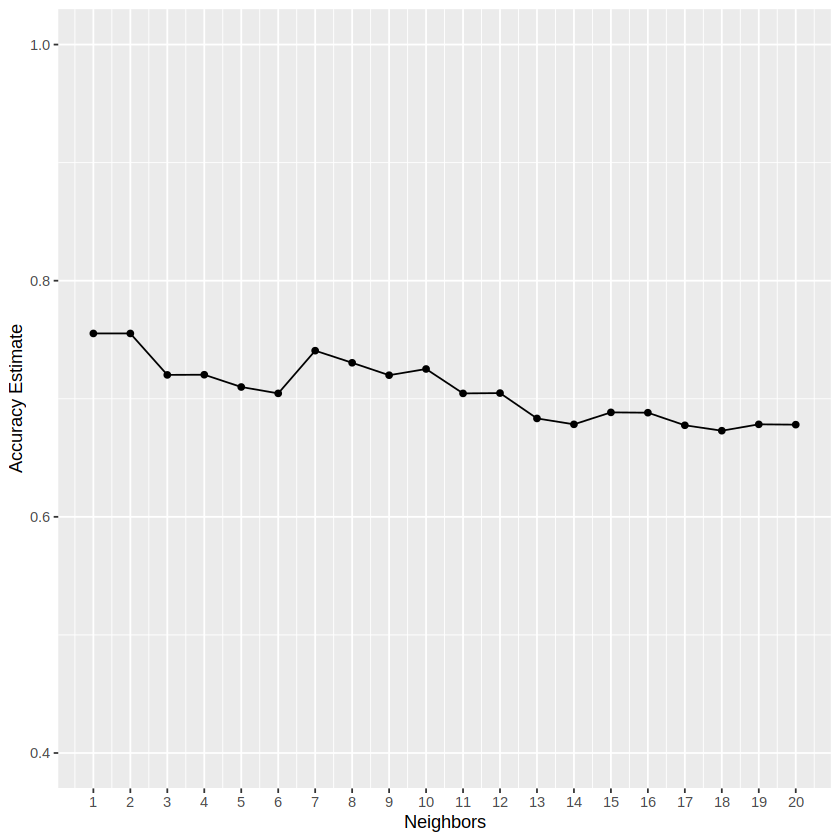

In [9]:
accuracies <- knn_results |>
                filter(.metric == "accuracy")
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

The graph shows that k = 1 and k = 2 have the highest accuracy. However, since the k values are too small in this case which could overfit the data, we decide to build 3 models with k values of 2, 7, and 8, to see which k value yields the highest accuracy on the training data set. 

In [10]:
# using k = 2 on the training dataset to train the model
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbor = 2) |>
            set_engine("kknn") |>
            set_mode("classification")

user_knowledge_fit_2 <- workflow() |>
                        add_recipe(user_knowledge_recipe) |>
                        add_model(knn_spec_2) |>
                        fit(data = user_knowledge_training)

user_knowledge_fit_2

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1484375
Best kernel: rectangular
Best k: 2

In [11]:
user_knowledge_test2_predictions <- predict(user_knowledge_fit_2, user_knowledge_testing) |>
                                    bind_cols(user_knowledge_testing)

head(user_knowledge_test2_predictions)

.pred_class,STG,SCG,STR,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Middle,0.10,0.10,0.43,0.29,0.56,Middle
High,0.00,0.00,0.50,0.20,0.85,High
High,0.18,0.18,0.55,0.30,0.81,High
Low,0.06,0.06,0.51,0.41,0.30,Low
High,0.10,0.10,0.70,0.15,0.90,High
Low,0.10,0.25,0.10,0.08,0.33,Low


In [12]:
# find the accuracy on the training data set with k = 2
user_knowledge_predictions2_accuracy <- metrics(user_knowledge_test2_predictions, truth = UNS, estimate = .pred_class)

user_knowledge_predictions2_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7575758
kap,multiclass,0.6456376


In [13]:
# using k = 7 on the training dataset to train the model
knn_spec_7 <- nearest_neighbor(weight_func = "rectangular", neighbor = 7) |>
            set_engine("kknn") |>
            set_mode("classification")

user_knowledge_fit_7 <- workflow() |>
                        add_recipe(user_knowledge_recipe) |>
                        add_model(knn_spec_7) |>
                        fit(data = user_knowledge_training)

user_knowledge_fit_7

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1757812
Best kernel: rectangular
Best k: 7

In [14]:
user_knowledge_test7_predictions <- predict(user_knowledge_fit_7, user_knowledge_testing) |>
                                    bind_cols(user_knowledge_testing)

head(user_knowledge_test7_predictions)

.pred_class,STG,SCG,STR,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Middle,0.10,0.10,0.43,0.29,0.56,Middle
High,0.00,0.00,0.50,0.20,0.85,High
High,0.18,0.18,0.55,0.30,0.81,High
very_low,0.06,0.06,0.51,0.41,0.30,Low
High,0.10,0.10,0.70,0.15,0.90,High
Low,0.10,0.25,0.10,0.08,0.33,Low


In [15]:
# find the accuracy on the training data set with k = 7
user_knowledge_predictions7_accuracy <- metrics(user_knowledge_test7_predictions, truth = UNS, estimate = .pred_class)

user_knowledge_predictions7_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7424242
kap,multiclass,0.6364226


In [16]:
# using k = 8 on the training dataset to train the model
knn_spec_8 <- nearest_neighbor(weight_func = "rectangular", neighbor = 8) |>
            set_engine("kknn") |>
            set_mode("classification")

user_knowledge_fit_8 <- workflow() |>
                        add_recipe(user_knowledge_recipe) |>
                        add_model(knn_spec_8) |>
                        fit(data = user_knowledge_training)

user_knowledge_fit_8

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(8,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1757812
Best kernel: rectangular
Best k: 8

In [17]:
user_knowledge_test8_predictions <- predict(user_knowledge_fit_8, user_knowledge_testing) |>
                                    bind_cols(user_knowledge_testing)

head(user_knowledge_test8_predictions)

.pred_class,STG,SCG,STR,LPR,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Middle,0.10,0.10,0.43,0.29,0.56,Middle
High,0.00,0.00,0.50,0.20,0.85,High
High,0.18,0.18,0.55,0.30,0.81,High
very_low,0.06,0.06,0.51,0.41,0.30,Low
High,0.10,0.10,0.70,0.15,0.90,High
Low,0.10,0.25,0.10,0.08,0.33,Low


In [18]:
# find the accuracy on the training data set with k = 8
user_knowledge_predictions8_accuracy <- metrics(user_knowledge_test8_predictions, truth = UNS, estimate = .pred_class)

user_knowledge_predictions8_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7424242
kap,multiclass,0.6357143


After finding the accuracy for each k values, we can see that the model with k = 2 still have the highest accuracy of 0.7575758. However, we can also use k = 7 or k = 8 since both of their accuracy are 0.7424242 which is very close to k = 2 and they are also less prone to overfit the data than k = 2.

In [19]:
# create a confusion matrix for the result
# user_knowledge_mat <- conf_mat(user_knowledge_test2_predictions, truth = UNS, estimate = .pred_class)

# user_knowledge_mat